version 3.1
## Set environment

In [ ]:
#!/bin/bash
#SBATCH -J GATK_BATCH
#SBATCH -p bio
#SBATCH -n 1
#SBATCH -c 4
#SBATCH --array=1-7
#SBATCH --output=%j.out
#SBATCH --error=%j.err

source /Share/samples/Acluster.sh
source /Share/home/chenhaodonglab/dengzg1993/bin/DZG_env.sh

## Global Parameters

These parameters generally do not require modification; just review them to ensure they are correct.  
Pay special attention to the **ploidy** setting — since this analysis involves *Physcomitrium patens*, it should be set to **haploid**.

---

### Note on Control Sample

**PP-1** represents the **wild-type (WT)** strain and is used as the **control** in this analysis.

---

### Required Files

The following files are required for this step:

- `PP-1.g.vcf.gz`
- `PP-1.g.vcf.gz.tbi`

These files were provided by the author as part of a reanalysis of the dataset from the following publication:  
[https://doi.org/10.1038/s41467-021-24546-2](https://doi.org/10.1038/s41467-021-24546-2)

Please **cite this publication** if you use the accompanying code or data.


In [ ]:
CurrentDIR=$(pwd)
TempDIR=/Share/home/dengzg1993/tmp

REF_FASTA=/Data/ChenhaodongLab/Data_deposited/Reference_genome/Physcomitrella/Gd_v6.1/Ppatens_870_V6.fasta

ANNOVAR=/Share/home/dengzg1993/tools/annovar
SPECIES=PP
ANNOV_DATABASE=/Data/ChenhaodongLab/Data_deposited/Reference_genome/Physcomitrella/Gd_v6.1/Anovar_db

PLOIDY=1

CONTROL=PP-1
CONTROL_GVCF=/Share/home/dengzg1993/Analyses/DNASeq/Physcomitrella/1.WGS/04.PP-1/2024.11.25_V6.1/3.output/PP-1.g.vcf.gz

## Read sample info

In [ ]:
dos2unix SampleList.tsv
TASK_ID=${SLURM_ARRAY_TASK_ID:-1}
LINE=$(sed -n "$((TASK_ID+1))p" SampleList.tsv)
SAMPLE=$(echo $LINE | awk '{print $1}')
READ1=$(echo $LINE | awk '{print $2}')
READ2=$(echo $LINE | awk '{print $3}')

log_step() {
    echo "[$(date '+%Y-%m-%d %H:%M:%S')] $1"
}

log_step "Start ($SAMPLE)"

# Estimate sequencing depth
estimate_depth() {
    local sample=$1
    local read1=$2
    local __resultvar=$3   

    NUM_READS_R1=$(zcat "$read1" | wc -l)
    NUM_READS_R1=$((NUM_READS_R1/4))

    GENOME_SIZE=$(grep -v ">" "$REF_FASTA" | wc -c)
    DEPTH=$(echo "$NUM_READS_R1 * 150 * 2 / $GENOME_SIZE" | bc)
	
    echo "Estimated depth is '$DEPTH' ($sample)"
	
    eval $__resultvar="'$DEPTH'"
}

estimate_depth "$SAMPLE" "$READ1" DEPTH

SAMPLEDIR=$CurrentDIR/$SAMPLE
mkdir -p $SAMPLEDIR/report $SAMPLEDIR/1.mapping $SAMPLEDIR/2.variants $SAMPLEDIR/3.output $SAMPLEDIR/4.annotate $SAMPLEDIR/clean_data

### Example of SampleList

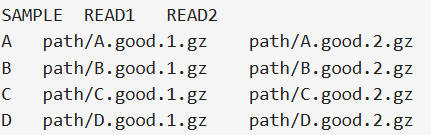

## 1.Trimmomatic

In [ ]:
TRIM_READ1=$SAMPLEDIR/clean_data/${SAMPLE}_R1_trimmed.fq.gz
TRIM_READ2=$SAMPLEDIR/clean_data/${SAMPLE}_R2_trimmed.fq.gz
TRIM_LOG=$SAMPLEDIR/clean_data/${SAMPLE}_trimmomatic.log

log_step "Trimmomatic ($SAMPLE)"
trimmomatic PE -threads 4 \
    $READ1 $READ2 \
    $TRIM_READ1 $SAMPLEDIR/clean_data/${SAMPLE}_R1_unpaired.fq.gz \
    $TRIM_READ2 $SAMPLEDIR/clean_data/${SAMPLE}_R2_unpaired.fq.gz \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 &> $TRIM_LOG

## 2. FastQC

In [ ]:
log_step "FastQC ($SAMPLE)"
fastqc -o $SAMPLEDIR/report --noextract $TRIM_READ1 $TRIM_READ2 &> $SAMPLEDIR/report/${SAMPLE}_fastqc.log
wait

## 3. Mapping & Deduplication

In [ ]:
log_step "Reads mapping and deduplication ($SAMPLE)"

bwa mem -t 4 -M \
    -R "@RG\tID:$SAMPLE\tLB:$SAMPLE\tPL:ILLUMINA\tPM:HISEQ\tSM:$SAMPLE" \
    $REF_FASTA $TRIM_READ1 $TRIM_READ2 \
    | samtools view -Sb - \
    | samtools sort -o $SAMPLEDIR/1.mapping/${SAMPLE}.sorted.bam

picard MarkDuplicates \
    -I $SAMPLEDIR/1.mapping/${SAMPLE}.sorted.bam \
    -M $SAMPLEDIR/1.mapping/${SAMPLE}.dedup_metrics.txt \
    --TMP_DIR $TempDIR \
    -O $SAMPLEDIR/1.mapping/${SAMPLE}.sorted_dedup_reads.bam

samtools index $SAMPLEDIR/1.mapping/${SAMPLE}.sorted_dedup_reads.bam

## 4. Variant Calling

In [ ]:
log_step "Variant calling by HaplotypeCaller ($SAMPLE)"

grep '>' $REF_FASTA | sed 's/>//' | cut -d ' ' -f 1 > $SAMPLEDIR/2.variants/chr.list.txt

while read CHR; do
    gatk HaplotypeCaller \
        -R $REF_FASTA \
        -I $SAMPLEDIR/1.mapping/${SAMPLE}.sorted_dedup_reads.bam \
        --intervals $CHR \
        --sample-ploidy $PLOIDY \
        -ERC GVCF \
        -O $SAMPLEDIR/2.variants/${SAMPLE}.${CHR}.g.vcf.gz
done < $SAMPLEDIR/2.variants/chr.list.txt

# Combine vcf
CHR_LIST=$SAMPLEDIR/2.variants/chr.list.txt
VCF_INPUTS=""
while read CHR; do
    VCF_INPUTS="$VCF_INPUTS -I $SAMPLEDIR/2.variants/${SAMPLE}.${CHR}.g.vcf.gz"
done < $CHR_LIST

gatk MergeVcfs $VCF_INPUTS -O $SAMPLEDIR/2.variants/${SAMPLE}.g.vcf.gz

cp $SAMPLEDIR/2.variants/${SAMPLE}.g.vcf.gz* $SAMPLEDIR/3.output/

## 5. Variant Filtration & Annotation

In [ ]:
gatk CombineGVCFs -R $REF_FASTA --variant $SAMPLEDIR/3.output/${SAMPLE}.g.vcf.gz --variant $CONTROL_GVCF -O $SAMPLEDIR/3.output/${SAMPLE}.combine.g.vcf.gz
gatk GenotypeGVCFs -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.combine.g.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.raw.vcf.gz

# SNP
gatk SelectVariants -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.raw.vcf.gz --select-type-to-include SNP --restrict-alleles-to BIALLELIC -O $SAMPLEDIR/3.output/${SAMPLE}.raw.snp.vcf.gz
gatk VariantFiltration -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.raw.snp.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.flag.snp.vcf.gz \
    -filter-name "hard_filter" -filter "QD < 2.0 || SOR > 3.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
gatk SelectVariants -V $SAMPLEDIR/3.output/${SAMPLE}.flag.snp.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.cleaned.snp.vcf.gz --exclude-filtered
gatk VariantFiltration -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.cleaned.snp.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.flag2.snp.vcf.gz \
    -filter-name "Mutant_in_WT_filter" -filter "vc.getGenotype('$CONTROL').getAlleles().contains(vc.getAlternateAllele(0))" \
    -filter-name "noCall_in_WT_filter" -filter "vc.getGenotype('$CONTROL').isNoCall()" \
    -filter-name "LowDP_in_SAMPLE_filter" -filter "vc.getGenotype('$SAMPLE').getDP() < 0.1 * $DEPTH" \
    -filter-name "het_in_SAMPLE_filter" -filter "vc.getGenotype('$SAMPLE').getAD().1 / vc.getGenotype('$SAMPLE').getDP() < 0.90"
gatk SelectVariants -V $SAMPLEDIR/3.output/${SAMPLE}.flag2.snp.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.final.snp.vcf.gz --exclude-filtered

# INDEL
gatk SelectVariants -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.raw.vcf.gz --select-type-to-include INDEL --restrict-alleles-to BIALLELIC -O $SAMPLEDIR/3.output/${SAMPLE}.raw.indel.vcf.gz
gatk VariantFiltration -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.raw.indel.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.flag.indel.vcf.gz \
    -filter-name "hard_filter" -filter "QD < 2.0 || FS > 200.0 || SOR > 10.0 || MQRankSum < -12.5 || ReadPosRankSum < -20.0"
gatk SelectVariants -V $SAMPLEDIR/3.output/${SAMPLE}.flag.indel.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.cleaned.indel.vcf.gz --exclude-filtered
gatk VariantFiltration -R $REF_FASTA -V $SAMPLEDIR/3.output/${SAMPLE}.cleaned.indel.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.flag2.indel.vcf.gz \
    -filter-name "Mutant_in_WT_filter" -filter "vc.getGenotype('$CONTROL').getAlleles().contains(vc.getAlternateAllele(0))" \
    -filter-name "noCall_in_WT_filter" -filter "vc.getGenotype('$CONTROL').isNoCall()" \
    -filter-name "LowDP_in_SAMPLE_filter" -filter "vc.getGenotype('$SAMPLE').getDP() < 0.1 * $DEPTH" \
    -filter-name "het_in_SAMPLE_filter" -filter "vc.getGenotype('$SAMPLE').getAD().1 / vc.getGenotype('$SAMPLE').getDP() < 0.90"
gatk SelectVariants -V $SAMPLEDIR/3.output/${SAMPLE}.flag2.indel.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.final.indel.vcf.gz --exclude-filtered

# combine and annotate
gatk MergeVcfs -I $SAMPLEDIR/3.output/${SAMPLE}.final.snp.vcf.gz -I $SAMPLEDIR/3.output/${SAMPLE}.final.indel.vcf.gz -O $SAMPLEDIR/3.output/${SAMPLE}.final.combine.vcf.gz
$ANNOVAR/convert2annovar.pl -format vcf4old --includeinfo $SAMPLEDIR/3.output/${SAMPLE}.final.combine.vcf.gz > $SAMPLEDIR/3.output/${SAMPLE}.combine.annovar
$ANNOVAR/annotate_variation.pl --geneanno --outfile $SAMPLEDIR/3.output/${SAMPLE}.combine --buildver $SPECIES $SAMPLEDIR/3.output/${SAMPLE}.combine.annovar $ANNOV_DATABASE

cp $SAMPLEDIR/3.output/${SAMPLE}.final.snp.vcf.gz $SAMPLEDIR/4.annotate/
cp $SAMPLEDIR/3.output/${SAMPLE}.final.indel.vcf.gz $SAMPLEDIR/4.annotate/
cp $SAMPLEDIR/3.output/${SAMPLE}.combine.variant_function $SAMPLEDIR/4.annotate/
cp $SAMPLEDIR/3.output/${SAMPLE}.combine.exonic_variant_function $SAMPLEDIR/4.annotate/

Recommended GATK parameters (hard_filter): the last four filters are custom-defined and can be adjusted as needed.
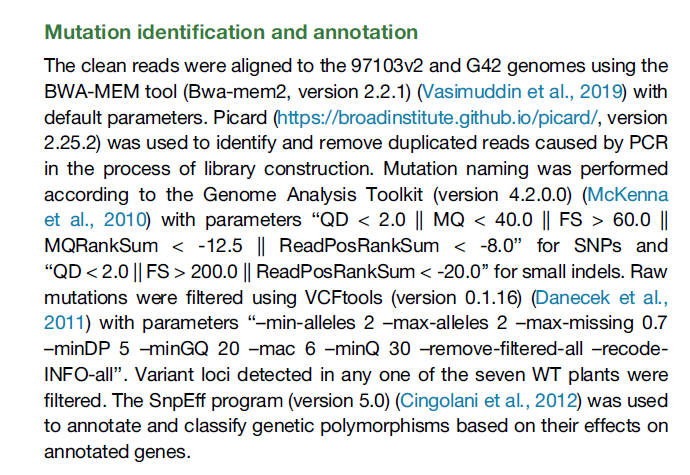

## 6. Optional: Clean up intermediate files

In [ ]:
BAM_FILE=$SAMPLEDIR/1.mapping/${SAMPLE}.sorted_dedup_reads.bam
if [[ -f "$BAM_FILE" && $(stat -c%s "$BAM_FILE") -gt $((1024**3)) ]]; then  
    rm -f $SAMPLEDIR/1.mapping/${SAMPLE}.sorted.bam
    rm -f $SAMPLEDIR/1.mapping/${SAMPLE}.sorted_dedup_reads.bam.bai
    rm -f $SAMPLEDIR/2.variants/${SAMPLE}.*.g.vcf.gz
    rm -f $SAMPLEDIR/2.variants/${SAMPLE}.*.g.vcf.gz.tbi
    rm -rf $SAMPLEDIR/clean_data
else
    log_step "BAM didn't generate correctly ($SAMPLE)"
fi